<a href="https://colab.research.google.com/github/Dheerajthummala/3d_model_Ai/blob/main/3d_model_ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu118
!pip install diffusers transformers accelerate safetensors
!pip install pillow numpy trimesh pygltflib


Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu118


In [9]:
!pip install trimesh pygltflib


In [10]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0))


CUDA available: True
GPU name: Tesla T4


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

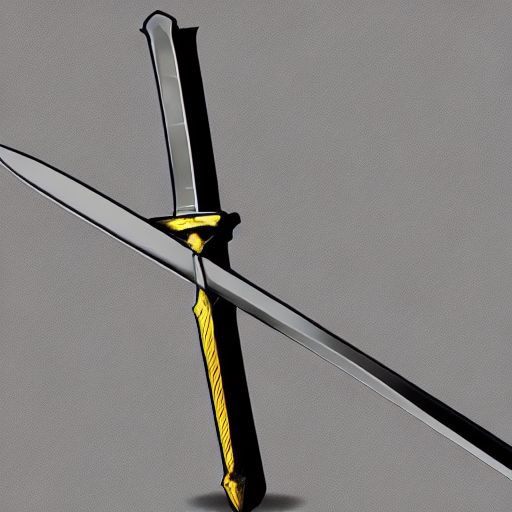

In [11]:
from diffusers import StableDiffusionPipeline
import torch

model_id = "runwayml/stable-diffusion-v1-5"

pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16
)

pipe = pipe.to("cuda")
pipe.enable_attention_slicing()  # safer on T4

prompt = "a chiar"

image = pipe(prompt, num_inference_steps=30).images[0]
image




In [35]:

import trimesh
import numpy as np

def generate_object(object_type, color=[180, 40, 40, 255]):
    meshes = []

    if object_type == "sword":
        blade = trimesh.creation.box(extents=(0.05, 0.02, 1.4))
        blade.apply_translation((0, 0, 0.7))

        guard = trimesh.creation.box(extents=(0.3, 0.05, 0.05))
        guard.apply_translation((0, 0, 0.05))

        handle = trimesh.creation.cylinder(radius=0.04, height=0.4)
        handle.apply_translation((0, 0, -0.2))

        pommel = trimesh.creation.icosphere(radius=0.06, subdivisions=3)
        pommel.apply_translation((0, 0, -0.45))

        meshes = [blade, guard, handle, pommel]

    elif object_type == "bottle":
        body = trimesh.creation.cylinder(radius=0.15, height=0.6)
        body.apply_translation((0, 0, 0.3))

        neck = trimesh.creation.cylinder(radius=0.07, height=0.2)
        neck.apply_translation((0, 0, 0.7))

        meshes = [body, neck]

    elif object_type == "cup":
        outer = trimesh.creation.cylinder(radius=0.15, height=0.3)
        inner = trimesh.creation.cylinder(radius=0.12, height=0.28)
        inner.apply_translation((0, 0, 0.01))

        cup = outer.difference(inner)
        meshes = [cup]

    elif object_type == "chair":
        seat = trimesh.creation.box(extents=(0.5, 0.5, 0.05))
        seat.apply_translation((0, 0, 0.45))

        back = trimesh.creation.box(extents=(0.5, 0.05, 0.5))
        back.apply_translation((0, -0.22, 0.7))

        legs = []
        for x in [-0.2, 0.2]:
            for y in [-0.2, 0.2]:
                leg = trimesh.creation.box(extents=(0.05, 0.05, 0.45))
                leg.apply_translation((x, y, 0.225))
                legs.append(leg)

        meshes = [seat, back] + legs

    elif object_type == "table":
        top = trimesh.creation.box(extents=(1.0, 0.6, 0.05))
        top.apply_translation((0, 0, 0.75))

        legs = []
        for x in [-0.45, 0.45]:
            for y in [-0.25, 0.25]:
                leg = trimesh.creation.box(extents=(0.05, 0.05, 0.75))
                leg.apply_translation((x, y, 0.375))
                legs.append(leg)

        meshes = [top] + legs

    else:
        meshes = [trimesh.creation.box(extents=(0.5, 0.5, 0.5))]

    final_mesh = trimesh.util.concatenate(meshes)
    final_mesh.visual.vertex_colors = color

    return final_mesh

In [36]:
def apply_material(mesh, material, base_color):
    material = material.lower()

    if material == "metal":
        # Darker, solid
        color = [int(c * 0.7) for c in base_color[:3]] + [255]

    elif material == "glass":
        # Light + transparent
        color = [220, 220, 255, 80]

    elif material == "wood":
        color = [139, 90, 43, 255]

    elif material == "plastic":
        color = base_color[:3] + [255]

    else:
        color = base_color[:3] + [255]

    mesh.visual.vertex_colors = color
    return mesh


In [37]:
def parse_prompt(prompt):
    p = prompt.lower()

    # Object
    if "sword" in p:
        obj = "sword"
    elif "bottle" in p:
        obj = "bottle"
    elif "cup" in p:
        obj = "cup"
    elif "chair" in p:
        obj = "chair"
    elif "table" in p:
        obj = "table"
    else:
        obj = "box"

    # Color
    if "red" in p:
        color = [200, 30, 30]
    elif "blue" in p:
        color = [40, 40, 200]
    elif "green" in p:
        color = [40, 180, 80]
    else:
        color = [180, 180, 180]

    # Material
    if "glass" in p:
        material = "glass"
    elif "metal" in p:
        material = "metal"
    elif "wood" in p:
        material = "wood"
    elif "plastic" in p:
        material = "plastic"
    else:
        material = "plastic"

    return obj, color, material


In [42]:
prompt = "a wooden chair"

obj, color, material = parse_prompt(prompt)

mesh = generate_object(obj, color)
mesh = apply_material(mesh, material, color)

mesh.export("output.glb")

print(f"Generated {material} {obj}")


Generated wood chair


In [43]:
from IPython.display import display
import trimesh

mesh = trimesh.load("output.glb")
mesh.show()
